# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with DeepMind Control Suite's `Cartpole` domain in `swingup` task.

### 1. Import the Necessary Packages

In [1]:
from dm_control import suite

import cv2
import glob
from PIL import Image
import subprocess
import numpy as np
from collections import deque
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

from td3 import TD3
import tensorflow as tf
from cpprb import ReplayBuffer, PrioritizedReplayBuffer

### 2. Instantiate the Environment and Agent

In [2]:
BUFFER_SIZE = int(1e5)
STATE_DIM = 5
ACTION_DIM = 1
BATCH_SIZE = 256

env = suite.load(domain_name='cartpole', task_name='swingup')
action_spec = env.action_spec()

agent = TD3(STATE_DIM, ACTION_DIM, max_action=action_spec.maximum)
print('Running on ', agent.device)

rb = ReplayBuffer(BUFFER_SIZE, {"obs": {"shape": (STATE_DIM,)},
                               "act": {"shape": ACTION_DIM},
                               "rew": {},
                               "next_obs": {"shape": (STATE_DIM,)},
                               "done": {}})

Running on  /CPU:0


### 3. Train the Agent with DDPG

Episode 2	Average Score: 73.92


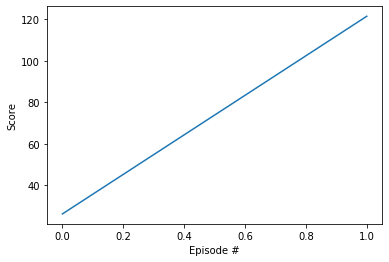

100%|██████████| 3/3 [04:02<00:00, 80.88s/it]


In [3]:
n_episodes=3; max_t=1e3; print_every=2
scores_deque = deque(maxlen=print_every)
scores = []

for i_episode in trange(1, int(n_episodes)+1):
    
    time_step = env.reset()
    state = np.concatenate( [ time_step.observation[key] 
                             for key in list( time_step.observation.keys() ) ] ).T
    score = 0
    
    for t in range(int(max_t)):
        
        action = agent.act(state)
        time_step = env.step(action)
        reward, done = time_step.reward, time_step.last()
        next_state = np.concatenate( [ time_step.observation[key] 
                                      for key in list( time_step.observation.keys() ) ] ).T
        
        # Learn, if enough samples are available in memory
        if rb.get_stored_size() > BATCH_SIZE:
            
            data = rb.sample(BATCH_SIZE)
            for k in data.keys():
                data[k] = data[k].astype('float64')
                
            states = data['obs']; actions = data['act']; rewards = data['rew']
            next_states = data['next_obs']; dones = data['done']
            
            agent.train_body(states, actions, next_states, rewards, dones)
        
        # Save experience / reward
        else:
            
            rb.add(obs=state, 
                   act=action, 
                   next_obs=next_state, 
                   rew=reward,
                   done=done)
            
        state = next_state
        score += reward

        if done:
            break

    scores_deque.append(score)
    scores.append(score)

    if i_episode % print_every == 0:
        
        tf.saved_model.save(agent.pi,'checkpoint_critic')
        tf.saved_model.save(agent.pi,'checkpoint_actor')

        clear_output(True)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')

        plt.show()


### 4. Watch a Smart Agent!

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# reset frames folder
subprocess.call([ 'rm', '-rf', 'frames'])
subprocess.call([ 'mkdir', '-p', 'frames'])

time_step = env.reset()
state = np.concatenate([time_step.observation[key] for key in list(time_step.observation.keys())])

agent.actor_local.eval()
agent.critic_local.eval()

with torch.no_grad():
    for t in trange(0, 700):
        action = agent.act(state)
        time_step = env.step(action)

        image_data = env.physics.render(height=480, width=480, camera_id=0)
        img = Image.fromarray(image_data, 'RGB')
        img.save("frames/frame-%.10d.png" % t)

        state = np.concatenate([time_step.observation[key] for key in list(time_step.observation.keys())])
        clear_output(True)
        if time_step.last():
            break



  2%|▏         | 15/700 [00:42<29:15,  2.56s/it]

In [10]:
# Convert frames to video
img_array = []
for filename in sorted(glob.glob('frames/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()